In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['figure.dpi']= 150

In [46]:
data = pd.read_csv('./data.csv')
data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,5664530014561852622,0,0,0,1240,0.067,0.035016,-7.268846,0,0.010,0.049516,-5.369901,1,1
1,2021-09-26 22:54:49.000000,1,1,5186611064559013950,0,0,1,1,0.002,0.054298,-2.657477,269,0.004,0.031942,-4.449220,1,1
2,2021-09-26 23:57:20.000000,2,2,2215519569292448030,3,0,0,2,0.014,0.014096,-3.824875,21,0.014,0.014906,-3.939309,1,1
3,2021-09-27 00:04:30.000000,3,3,6262169206735077204,0,1,1,3,0.012,0.015232,-3.461357,99,0.006,0.050671,-3.418403,1,1
4,2021-09-27 00:06:21.000000,4,4,4778985830203613115,0,1,0,4,0.019,0.051265,-4.009026,11464230,6.790,0.032005,-2.828797,1,1


In [4]:
data.drop(["oaid_hash", "banner_id0", "banner_id1", "rate0", "rate1", "g0", "g1", "coeff_sum0", "coeff_sum1"], axis=1, inplace=True)

In [5]:
data

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,0,0,0,1,1
1,2021-09-26 22:54:49.000000,1,1,0,0,1,1,1
2,2021-09-26 23:57:20.000000,2,2,3,0,0,1,1
3,2021-09-27 00:04:30.000000,3,3,0,1,1,1,1
4,2021-09-27 00:06:21.000000,4,4,0,1,0,1,1
...,...,...,...,...,...,...,...,...
15821467,2021-10-02 15:51:35.000000,146,530,0,2,9,1,0
15821468,2021-09-27 22:03:14.000000,12,22,0,1,6,1,0
15821469,2021-10-02 17:41:10.000000,12,1236,0,2,0,1,0
15821470,2021-09-29 00:39:32.000000,967,21,0,0,0,1,0


**Посчитаем статистику для фичей, где это имеет смысл. Построим гистограммы и посчитаем уникальные значения для категориальных признаков**

In [6]:
def analysis(data: pd.DataFrame):
    print(data[["campaign_clicks", "impressions", "clicks",]].describe())
    for field in ["zone_id", "banner_id", "os_id", "country_id",]:
        print(f"Unique {field}:", len(np.unique(data[field])))
        plt.hist(data[field], bins=min(30, len(np.unique(data[field]))))
        plt.show()

       campaign_clicks  impressions        clicks
count     1.582147e+07   15821472.0  1.582147e+07
mean      6.238540e-01          1.0  2.668835e-02
std       9.249152e+00          0.0  1.611710e-01
min       0.000000e+00          1.0  0.000000e+00
25%       0.000000e+00          1.0  0.000000e+00
50%       0.000000e+00          1.0  0.000000e+00
75%       0.000000e+00          1.0  0.000000e+00
max       8.290000e+02          1.0  1.000000e+00
Unique zone_id: 3444


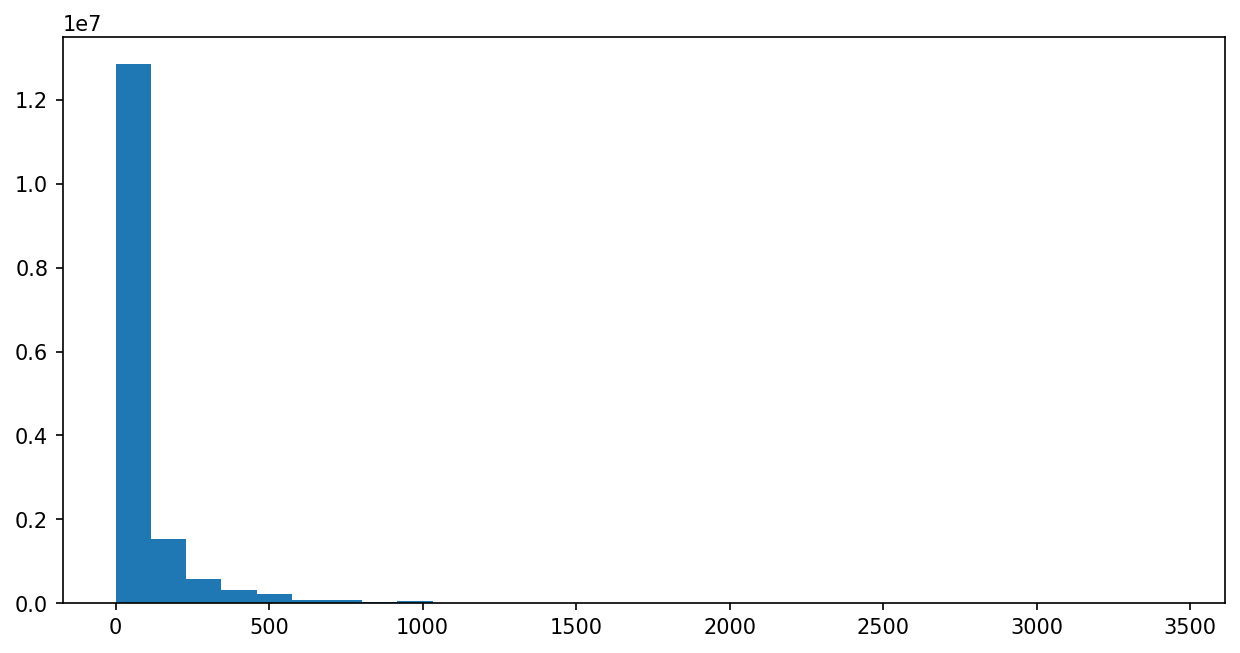

Unique banner_id: 1633


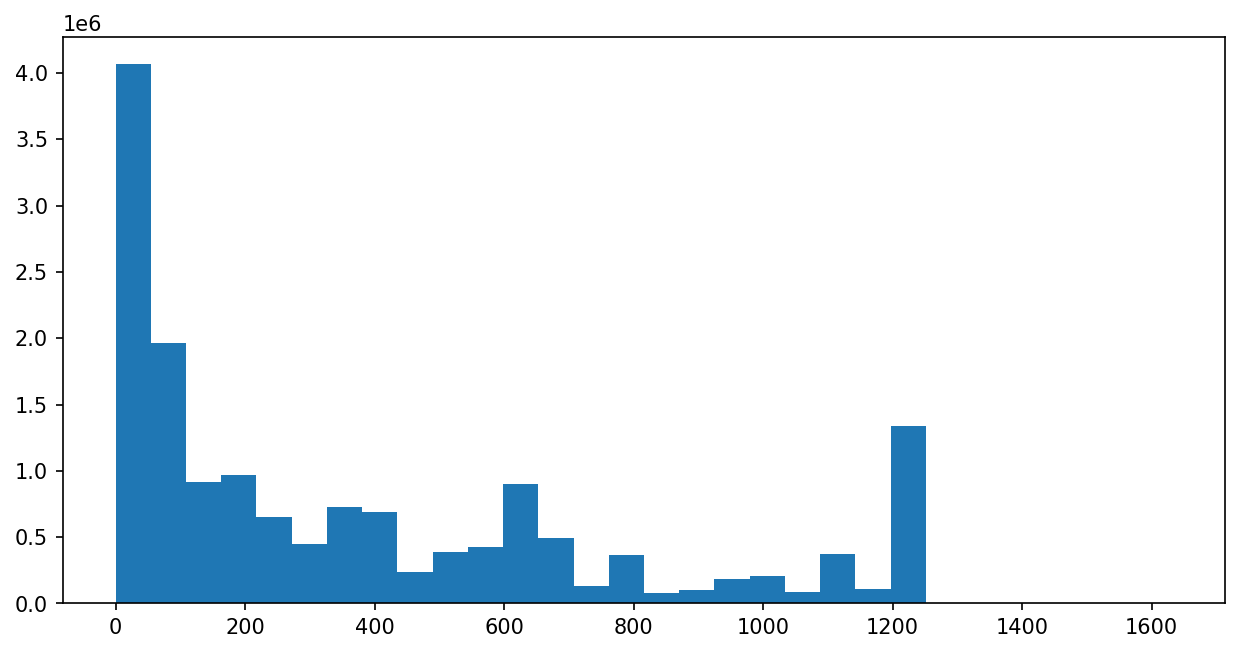

Unique os_id: 11


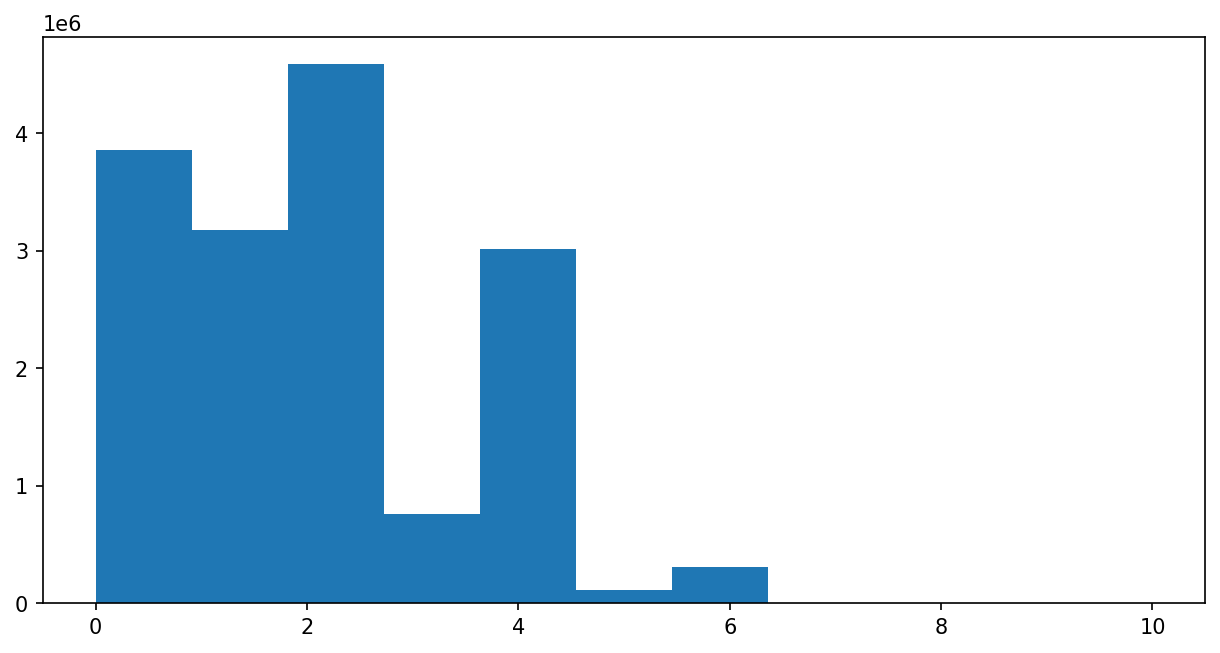

Unique country_id: 17


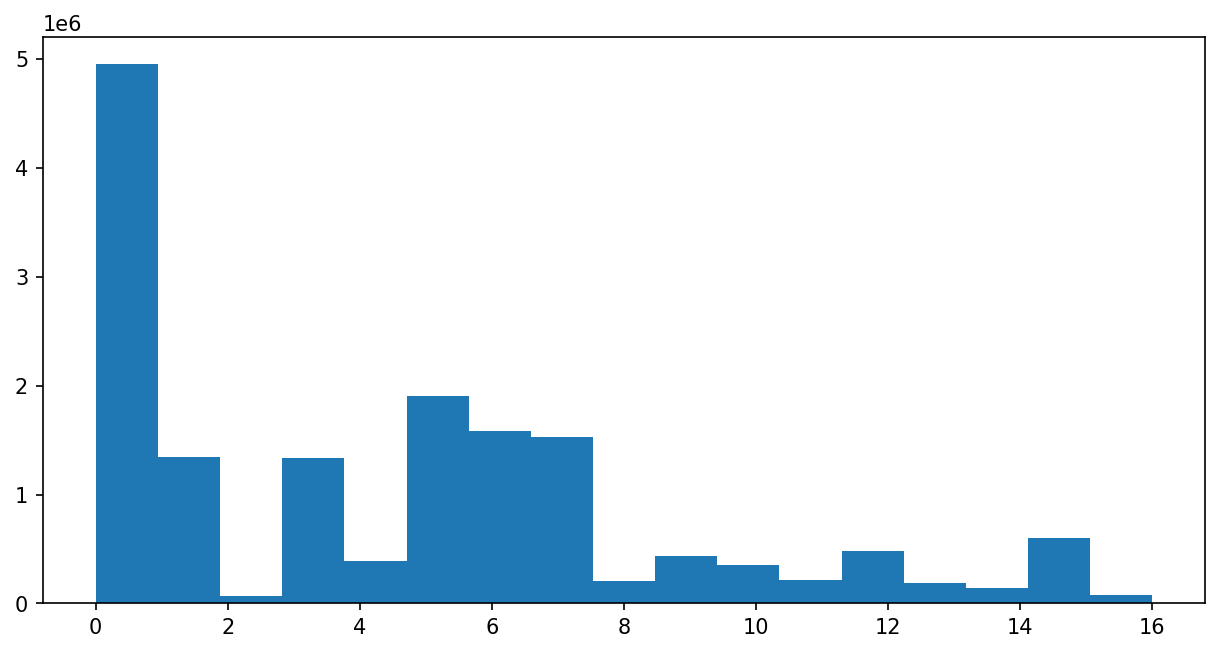

In [7]:
analysis(data)

In [8]:
categorical_features = ["zone_id", "banner_id", "os_id", "country_id",]

**У некоторых категориальных фичей много различных значений. Часть категорий встречается очень редко. Объединим редкие категории в одну (редкость определяется константой FITLERING_FRACTION), это упростит дальнейшую работу, т.к. иначе данные могут начать занимать много места, а обучение алгоритмов потребует большего количества времени. Все категориальные фичи кодируем с помощью one-hot-encoding**

In [9]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    FITLERING_FRACTION = 0.05
    RELABEL = 100000000000
    size = len(data)
    threshold = size * FITLERING_FRACTION
    
    for field in categorical_features:
        print(field)
        uniques = np.unique(data[field])
        mapping = {i: i for i in uniques}
        for val in uniques:
            ids = data[field] == val 
            if np.sum(ids) < threshold:
                mapping[val] = RELABEL
        data[field] = data[field].map(mapping)

    for field in categorical_features:
        one_hot = pd.get_dummies(data[field])
        data = data.drop(field,axis = 1)
        data = data.join(one_hot, lsuffix=f"{field}_")
    return data

In [10]:
data = feature_engineering(data)

zone_id
banner_id
os_id
country_id


In [11]:
# data.to_csv("data_features_1.csv", index=False)

In [12]:
# !cp ./data_features_1.csv /content/drive/MyDrive/

**Разделим данные на обучающую выборку и тестовую (последний день лога) по дате и выкинем эту фичу, т.к. не хочется захламлять фичи по указанным ранее причинам**

In [47]:
max(data["date_time"])

'2021-10-02 23:59:59.000000'

In [16]:
max_date = "2021-10-02"

In [17]:
last_day_data = data[data.date_time.apply(lambda d: max_date in d)]

In [18]:
data.drop(last_day_data.index, inplace=True)

In [19]:
data.drop(["date_time"], axis=1, inplace=True)
last_day_data.drop(["date_time"], axis=1, inplace=True)

/tmp/ipykernel_16715/4180371495.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_day_data.drop(["date_time"], axis=1, inplace=True)


**Первая модель, которую попробуем будет линейная модель, обучающаяся градиентым спуском**

In [20]:
def create_model(data: pd.DataFrame):
    classifier = SGDClassifier(loss="modified_huber", alpha=0.1)
    return classifier

In [29]:
def cv(data: pd.DataFrame, get_model):
    classifier = get_model(data)
    y = data["clicks"]
    X = data.drop(["clicks"], axis=1)
    cv_results = cross_validate(classifier, X=X, y=y, cv=5, scoring=["neg_log_loss", "roc_auc", "accuracy"], n_jobs=-1)
    print("Negative log loss", np.mean(cv_results["test_neg_log_loss"]))
    print("ROC AUC", np.mean(cv_results["test_roc_auc"]))
    print("Accuracy", np.mean(cv_results["test_accuracy"]))

In [52]:
cv(data, create_model) # alpha = default (very small)

Negative log loss -0.1556836361695524
ROC AUC 0.61082938431054
Accuracy 0.9746659008943249


In [67]:
cv(data, create_model)

Negative log loss -0.11583196017605979
ROC AUC 0.6317082555803586
Accuracy 0.9746659008943249


**В качестве модели без SGD возьмем Random Forest**

In [30]:
from sklearn.ensemble import RandomForestClassifier
def create_forest(data: pd.DataFrame):
    classifier = RandomForestClassifier(n_estimators=10, max_depth=10)
    return classifier

In [31]:
cv(data, create_forest)

Negative log loss -0.11400949411424988
ROC AUC 0.6603276764278029
Accuracy 0.9746656087634896


**Обучим на всем обучающем сете и посчитаем метрики на тестовой выборке. В качестве бейзлайна возьмем константую вероятность клика (он был выше, когда считали статистики)**

In [33]:
X = data.drop(["clicks"], axis=1)
y = data["clicks"]

In [35]:
X_test = last_day_data.drop(["clicks"], axis=1)
y_test = last_day_data["clicks"]

In [32]:
clf = create_model(data)

In [34]:
clf.fit(X, y)

SGDClassifier(alpha=0.1, loss='modified_huber')

In [36]:
y_pred = clf.predict_proba(X_test)

In [37]:
from sklearn.metrics import log_loss, roc_auc_score

In [41]:
forest = RandomForestClassifier(n_estimators=10, max_depth=10)

In [42]:
forest.fit(X, y)

RandomForestClassifier(max_depth=10, n_estimators=10)

In [43]:
y_pred_f = forest.predict_proba(X_test)

In [39]:
baseline_prob = 2.668835e-02

In [40]:
print("Baseline score")
print("Log loss", log_loss(y_test, [(1 - baseline_prob, baseline_prob)] * len(y_test)))
print("ROC AUC", roc_auc_score([(1, 0) if i == 0 else (0, 1) for i in y_test], [(1 - baseline_prob, baseline_prob)] * len(y_test)))

Baseline score
Log loss 0.1543597873573571
ROC AUC 0.5


In [38]:
print("SGD algo score")
print("Log loss", log_loss(y_test, y_pred))
print("ROC AUC", roc_auc_score([(1, 0) if i == 0 else (0, 1) for i in y_test], y_pred))

SGD algo score
Log loss 0.14519220892845874
ROC AUC 0.7220394811340641


In [44]:
print("Forest algo score")
print("Log loss", log_loss(y_test, y_pred_f))
print("ROC AUC", roc_auc_score([(1, 0) if i == 0 else (0, 1) for i in y_test], y_pred_f))

Forest algo score
Log loss 0.1386432334524506
ROC AUC 0.7383851118178257


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


**Оба алгоритма работают лучше, чем бейзлайн. Random Forest немного лучше линейной модели. Скорее всего результаты можно сильно улучшить, если больше перебрать сетку гиперпарметров (сейчас был минимальный перебор руками). К сожалению, для перебора у меня нет ресурсов**